In [6]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import random
import os
import datetime

# Machine learning tools
import umap
from sklearn.linear_model import LinearRegression
import torch
import torch.utils.data
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.model_selection import ShuffleSplit

# File load and save imports
from utils import *
import segypy 
import pickle

# widget imports
from ipywidgets import interact, VBox, HBox
import ipywidgets as widgets
from IPython.display import clear_output

# Tensor board
from tensorboardX import SummaryWriter

# live loss plots
from livelossplot import PlotLosses

In [26]:
from SeismicReduction import *

def flatten_on_horizon(amplitude, horizon, twt, top_add=12, below_add=52):
    traces = np.zeros((horizon.shape[0], horizon.shape[1], top_add+below_add))
    for i in range(horizon.shape[0]):
        hrz_idx = [np.abs(twt-val).argmin() for val in horizon[i, :]]
        for j in range(horizon.shape[1]):
            traces[i, j, :] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]

    return traces

In [17]:
near_stack_amplitudes, twt = load_seismic('./data/3d_nearstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])
far_stack_amplitudes, _ = load_seismic('./data/3d_farstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

SegyPY0.57:  readSegy : Trying to read ./data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ./data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


In [28]:
horizon = load_horizon('./data/Top_Heimdal_subset.txt', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])
interpolate_horizon(horizon)
near_traces = flatten_on_horizon(near_stack_amplitudes, horizon, twt, top_add=12, below_add=52)
far_traces = flatten_on_horizon(far_stack_amplitudes, horizon, twt, top_add=12, below_add=52)

In [29]:
well_i, well_x = 36, 276//2
well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))

near_traces /= well_variance_near
far_traces /= well_variance_far

In [30]:
near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb = far_traces.reshape(-1, 64)

In [31]:
stacked = np.concatenate([far_traces_emb, near_traces_emb], 1)

In [33]:
plot = umap.UMAP(n_neighbors=50,
                          min_dist=0.001,
                          metric='correlation', 
                                   verbose=True,
                                random_state=42).fit_transform(stacked)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


<class 'numpy.ndarray'> (25351, 2)


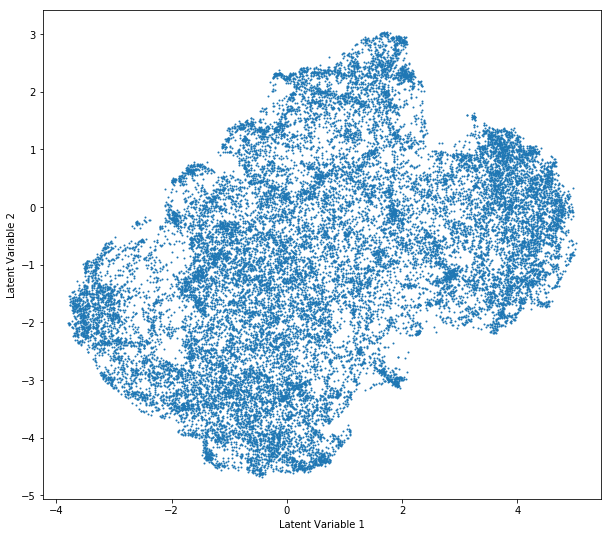

In [37]:
print(type(plot), plot.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set(xlabel='Latent Variable 1', ylabel='Latent Variable 2',
       aspect='equal')
sc = ax.scatter(plot[:, 0], plot[:, 1], s=1.0)
plt.show()

In [38]:
np.save('test_cases/Flat-top12,bottom52,UMAP-neigh50,dist0.001.npy', plot)    # .npy extension is added if not given


In [39]:
near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb = far_traces.reshape(-1, 64)